In [ ]:
import math # Mathematical functions 

In [ ]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'

Tensorflow Version: 2.12.0
Num GPUs: 1


In [ ]:
df = pd.read_csv('/content/TSPC.JK.csv',parse_dates=['Date'], index_col="Date")

In [ ]:
data = df
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-01,1405.0,1405.0,1385.0,1390.0,1390.0,327700
2023-02-02,1395.0,1420.0,1390.0,1410.0,1410.0,322900
2023-02-03,1410.0,1415.0,1390.0,1415.0,1415.0,958100
2023-02-06,1415.0,1415.0,1405.0,1415.0,1415.0,542000
2023-02-07,1415.0,1420.0,1405.0,1420.0,1420.0,199200


In [ ]:
df.isna().sum()
print(df)

              Open    High     Low   Close  Adj Close   Volume
Date                                                          
2023-02-01  1405.0  1405.0  1385.0  1390.0     1390.0   327700
2023-02-02  1395.0  1420.0  1390.0  1410.0     1410.0   322900
2023-02-03  1410.0  1415.0  1390.0  1415.0     1415.0   958100
2023-02-06  1415.0  1415.0  1405.0  1415.0     1415.0   542000
2023-02-07  1415.0  1420.0  1405.0  1420.0     1420.0   199200
2023-02-08  1420.0  1425.0  1405.0  1415.0     1415.0   141000
2023-02-09  1415.0  1415.0  1405.0  1415.0     1415.0   498800
2023-02-10  1415.0  1415.0  1405.0  1410.0     1410.0   494000
2023-02-13  1415.0  1415.0  1405.0  1405.0     1405.0   217800
2023-02-14  1410.0  1415.0  1395.0  1410.0     1410.0   635900
2023-02-15  1410.0  1415.0  1400.0  1415.0     1415.0   721800
2023-02-16  1415.0  1420.0  1405.0  1415.0     1415.0  1182100
2023-02-17  1415.0  1415.0  1405.0  1410.0     1410.0   751000
2023-02-20  1410.0  1415.0  1390.0  1400.0     1400.0  

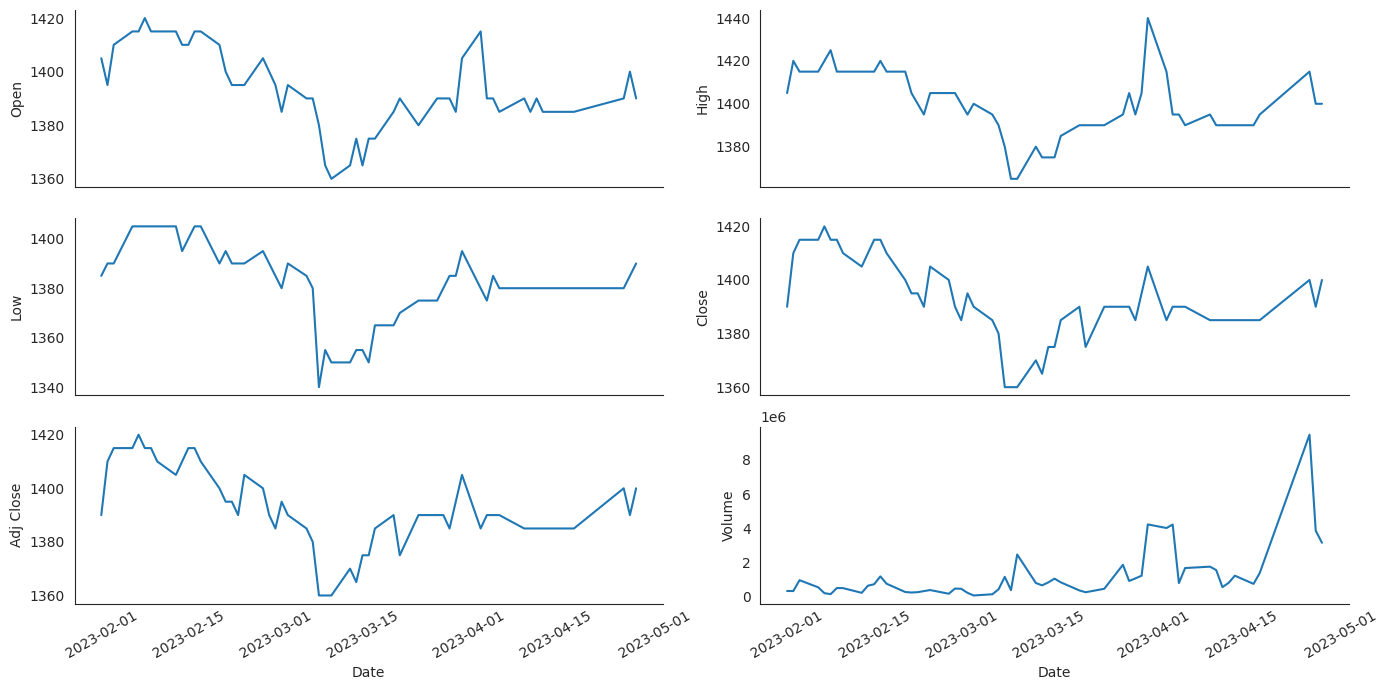

In [ ]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [ ]:
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-04-17,1390.0,1380.0,1385.0,1385.0,742900,1385.0
2023-04-18,1395.0,1380.0,1385.0,1385.0,1382400,1385.0
2023-04-26,1415.0,1380.0,1390.0,1400.0,9478900,1400.0
2023-04-27,1400.0,1385.0,1400.0,1390.0,3856900,1390.0
2023-04-28,1400.0,1390.0,1390.0,1400.0,3152900,1400.0


In [ ]:
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(55, 5)


In [ ]:
sequence_length = 10

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(34, 10, 5) (34,)
(11, 10, 5) (11,)
0.9166666666666643
0.9166666666666643


In [ ]:
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

50 10 5


In [ ]:
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
3/3 [==============================] - 5s 363ms/step - loss: 0.2956 - val_loss: 0.0458
Epoch 2/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0684 - val_loss: 0.0358
Epoch 3/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0714 - val_loss: 0.0713
Epoch 4/10
3/3 [==============================] - 0s 19ms/step - loss: 0.0991 - val_loss: 0.0408
Epoch 5/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0640 - val_loss: 0.0146
Epoch 6/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0418 - val_loss: 0.0198
Epoch 7/10
3/3 [==============================] - 0s 19ms/step - loss: 0.0522 - val_loss: 0.0313
Epoch 8/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0619 - val_loss: 0.0301
Epoch 9/10
3/3 [==============================] - 0s 18ms/step - loss: 0.0591 - val_loss: 0.0214
Epoch 10/10
3/3 [==============================] - 0s 26ms/step - loss: 0.0492 - val_loss: 0.0145


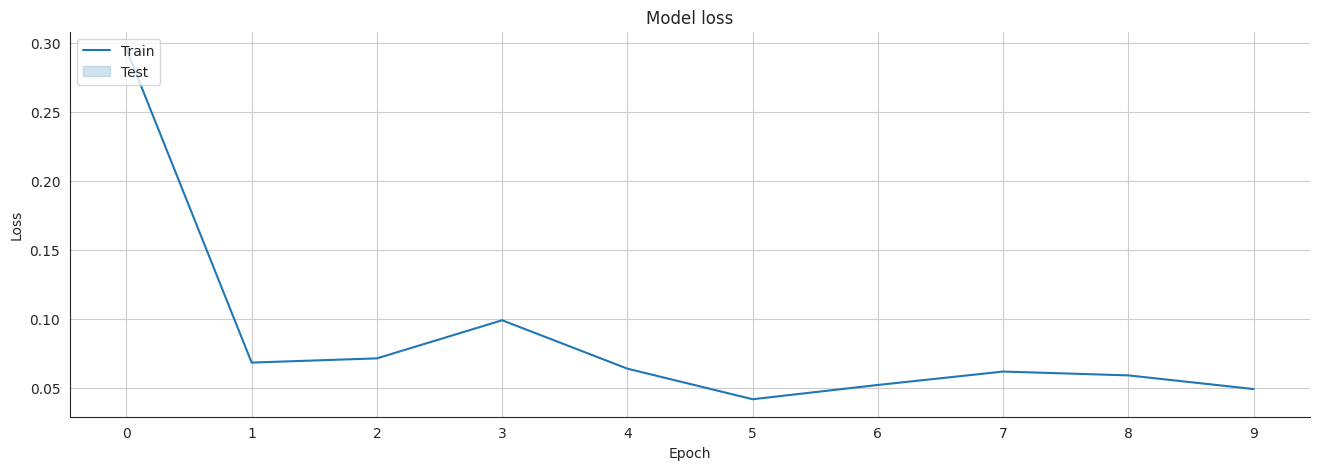

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

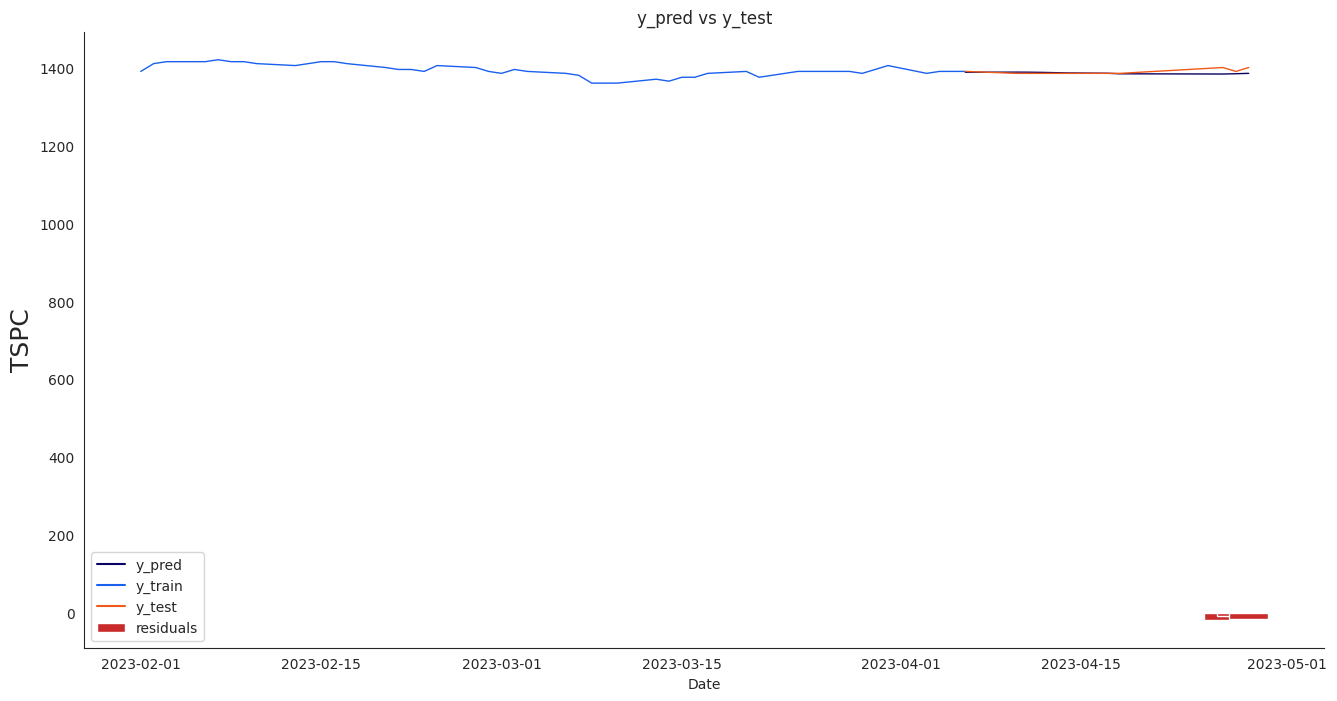

In [ ]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("TSPC", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

last_N_days

array([[1.3950e+03, 1.3800e+03, 1.3900e+03, 1.3850e+03, 1.7510e+06],
       [1.3900e+03, 1.3800e+03, 1.3850e+03, 1.3850e+03, 1.5493e+06],
       [1.3900e+03, 1.3800e+03, 1.3900e+03, 1.3850e+03, 5.5210e+05],
       [1.3900e+03, 1.3800e+03, 1.3850e+03, 1.3850e+03, 8.0420e+05],
       [1.3900e+03, 1.3800e+03, 1.3850e+03, 1.3850e+03, 1.2228e+06],
       [1.3900e+03, 1.3800e+03, 1.3850e+03, 1.3850e+03, 7.4290e+05],
       [1.3950e+03, 1.3800e+03, 1.3850e+03, 1.3850e+03, 1.3824e+06],
       [1.4150e+03, 1.3800e+03, 1.3900e+03, 1.4000e+03, 9.4789e+06],
       [1.4000e+03, 1.3850e+03, 1.4000e+03, 1.3900e+03, 3.8569e+06],
       [1.4000e+03, 1.3900e+03, 1.3900e+03, 1.4000e+03, 3.1529e+06]])

In [ ]:
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

1/1 [==============================] - 0s 32ms/step


In [ ]:
predicted_price

1386.03